In [1]:
import pandas
data = pandas.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Populating the interactive namespace from numpy and matplotlib


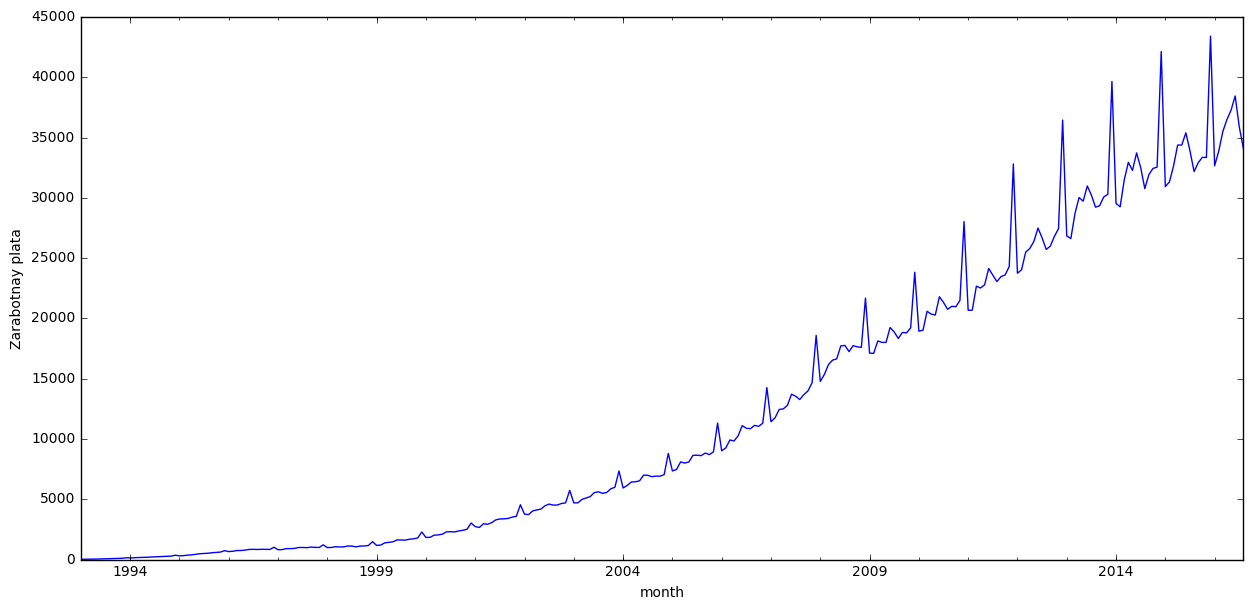

In [2]:
%pylab inline
import numpy
import matplotlib.pyplot as plt
plt.figure(figsize(15,7))
data['WAG_C_M'].plot()
plt.ylabel(u'Zarabotnay plata')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


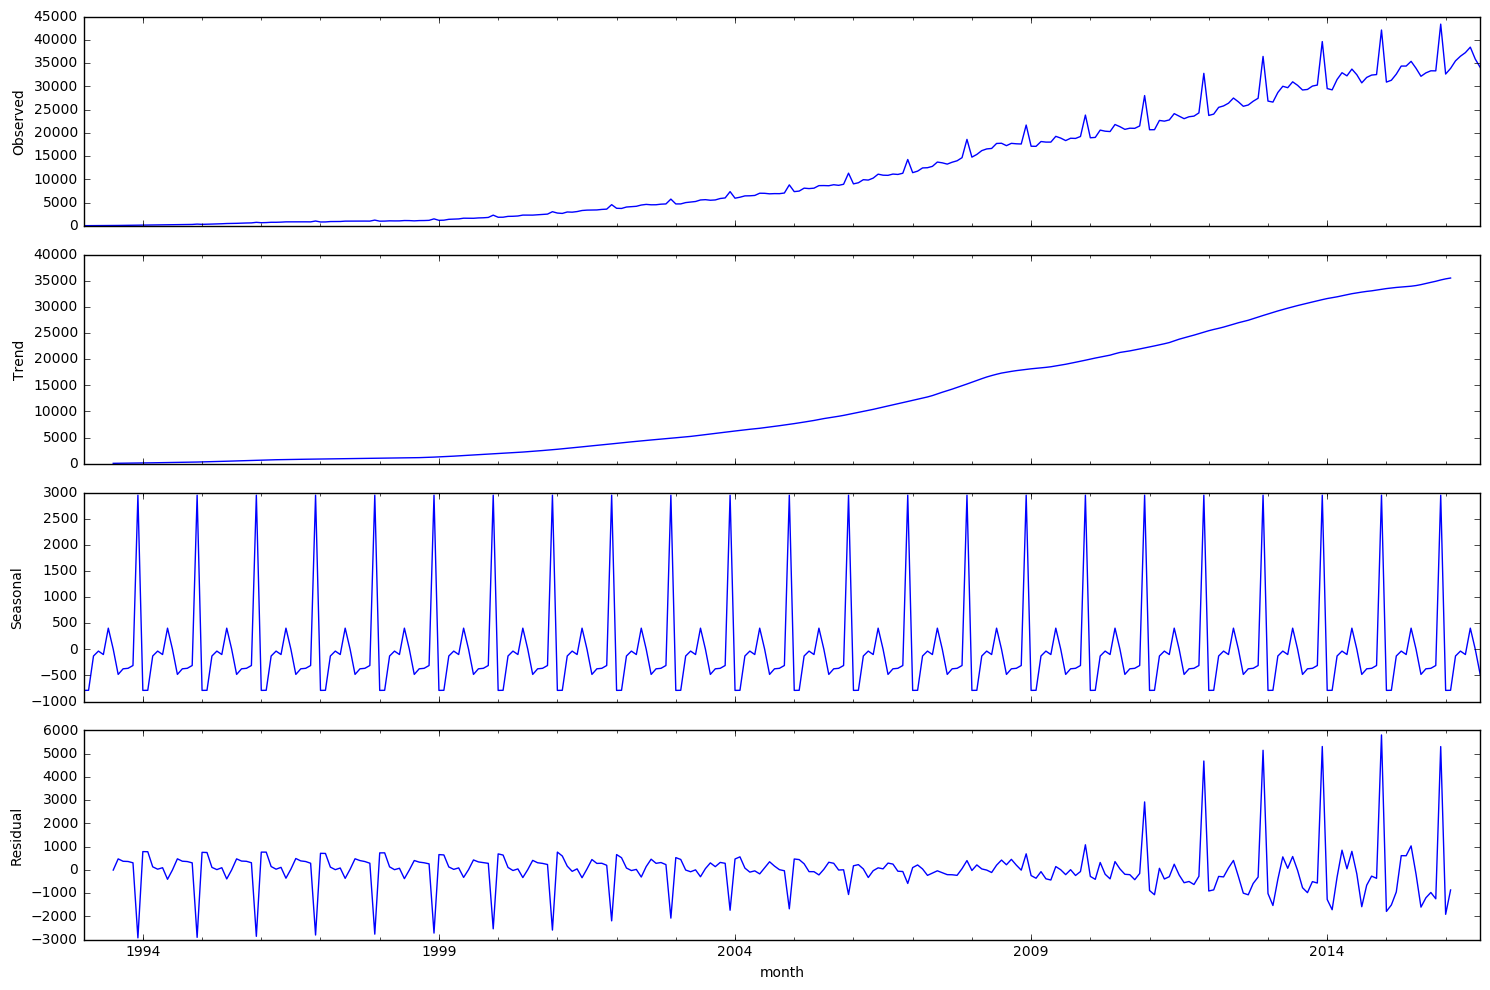

In [3]:
#график имеет тренд и нестационарен. 
#Проверим критерием Дики-Фуллера гипотезу H0: о нестационарности, а также сделаем STL-декомпозицию ряда
plt.figure(figsize(15,10))
import statsmodels.api as sm
sm.tsa.seasonal_decompose(data['WAG_C_M']).plot()
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M'])[1]

Опт. параметр преобразования Бокса-кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


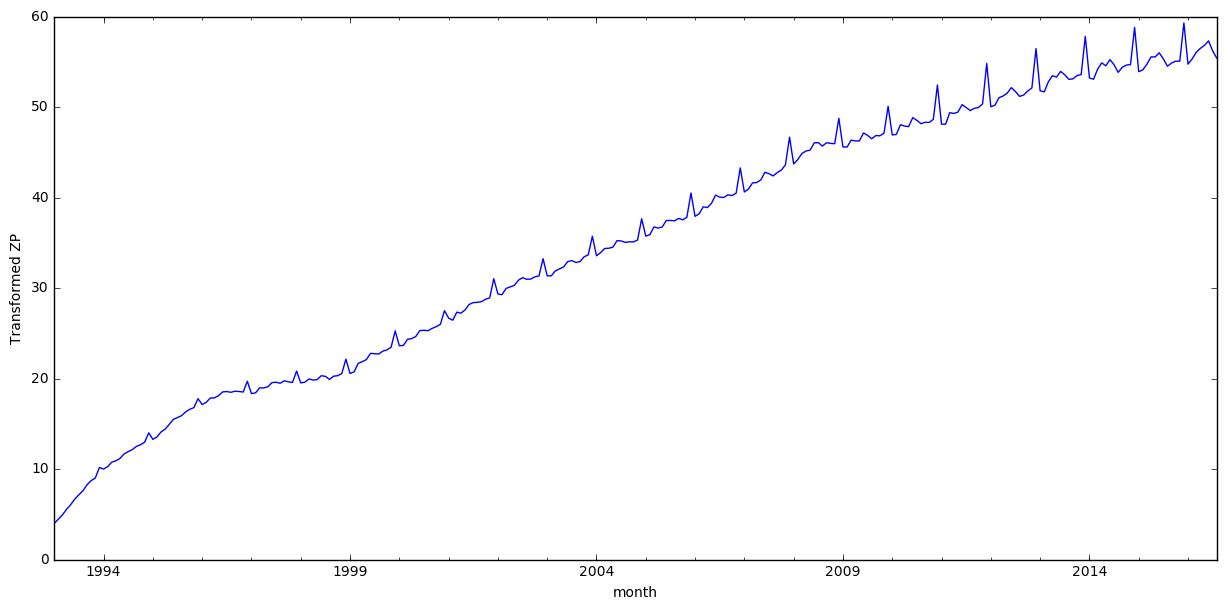

In [4]:
#Нельзя отвергнуть гипотезы о нестационарности, т.к. уровень значимости больше 0.05

#Стабилизация дисперсии

#Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

from scipy import stats
data['zp_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.zp_box.plot()
plt.ylabel(u'Transformed ZP')
print "Опт. параметр преобразования Бокса-кокса: %f" % lmbda
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.zp_box)[1]

Критерий Дики-Фуллера: p=0.014697


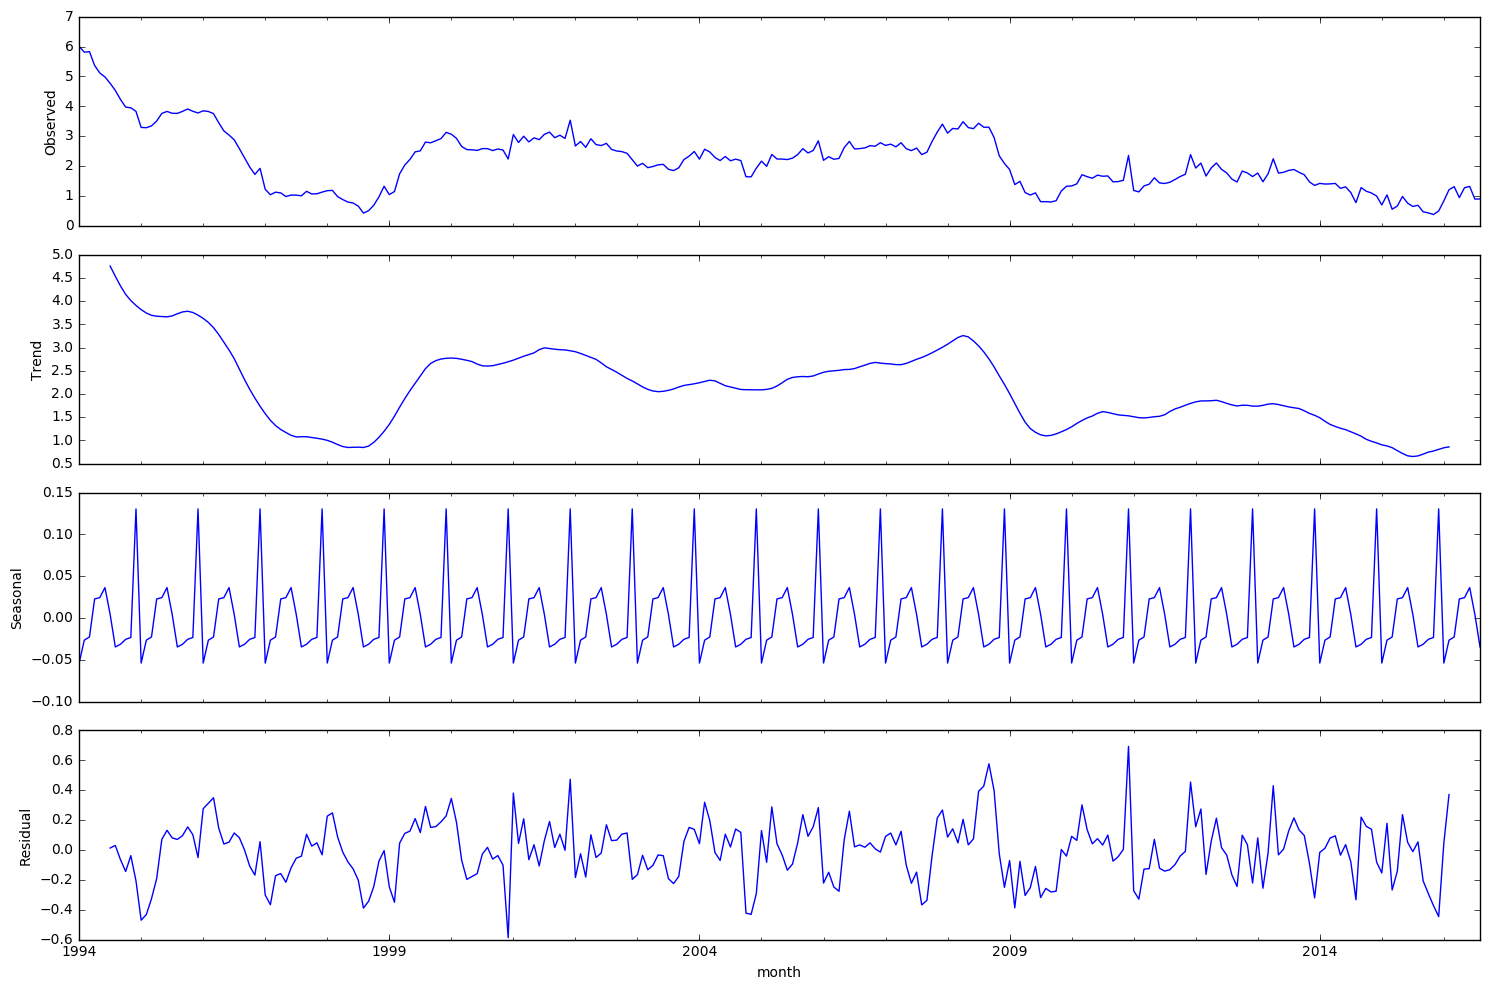

In [5]:
#ряд не стационарен, т.к. критерий все еще больше уровня значимости 0.05.

#Выбор порядка дифференцирования

#Попробуем сезонное дифференцирование. Сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

data['zp_box_diff'] = data.zp_box - data.zp_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.zp_box_diff[12:]).plot()
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.zp_box_diff[12:])[1]

Критерий Дики-Фуллера: p=0.000000


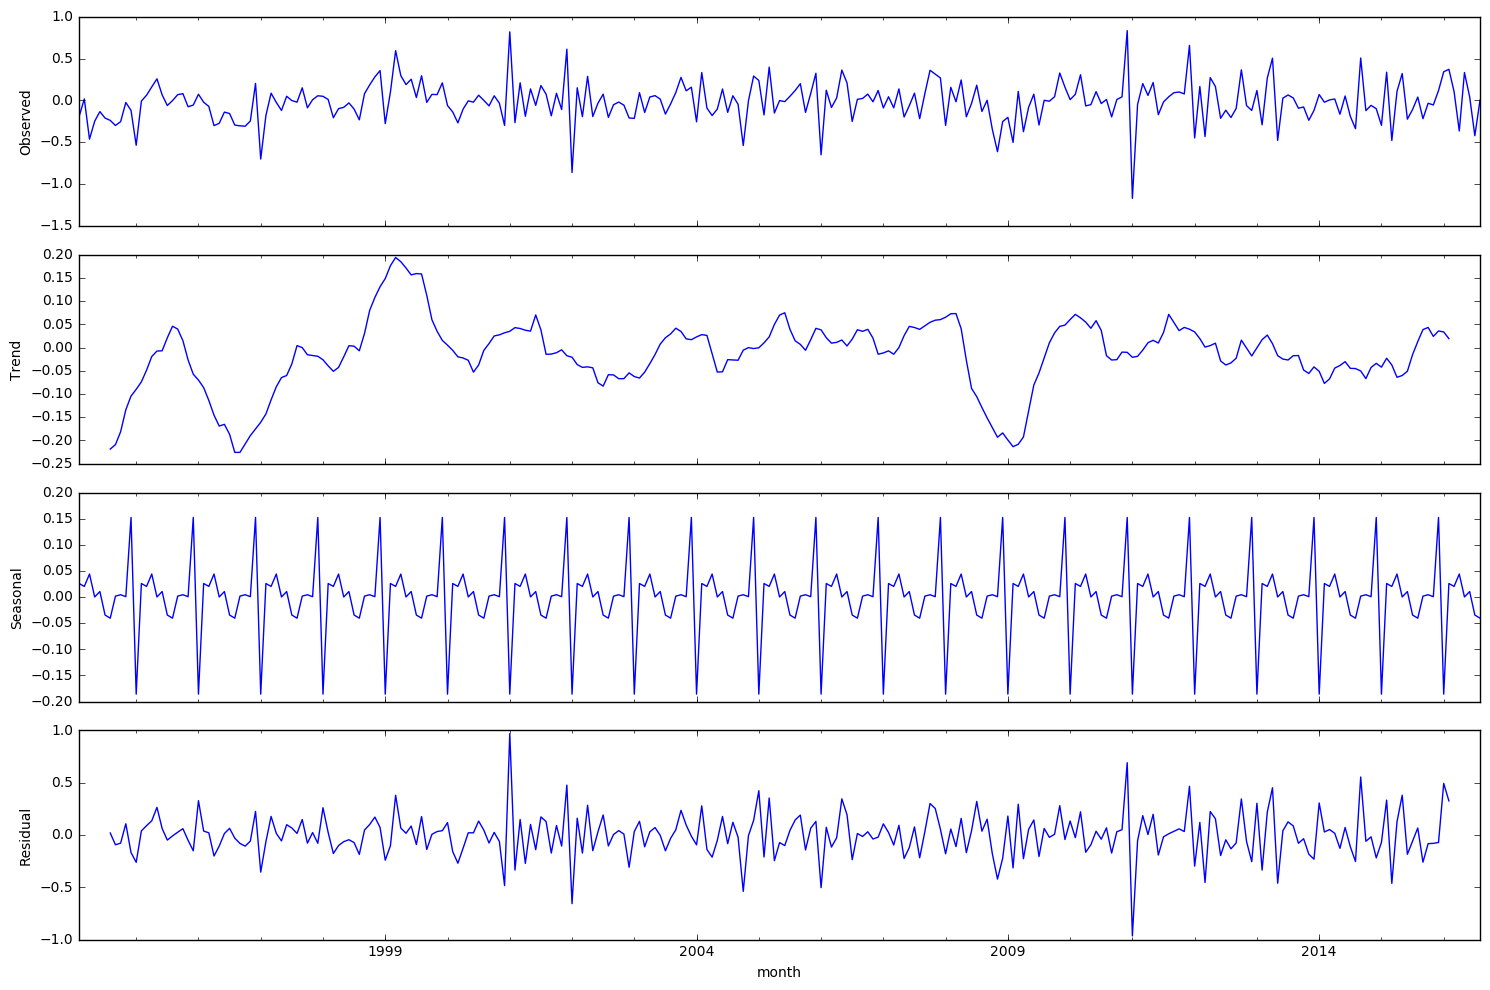

In [6]:
# Добавим еще обычное дифференцирование, чтобы избавиться от тренда

data['zp_box_diff2'] = data.zp_box_diff - data.zp_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.zp_box_diff2[13:]).plot()
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.zp_box_diff2[13:])[1]

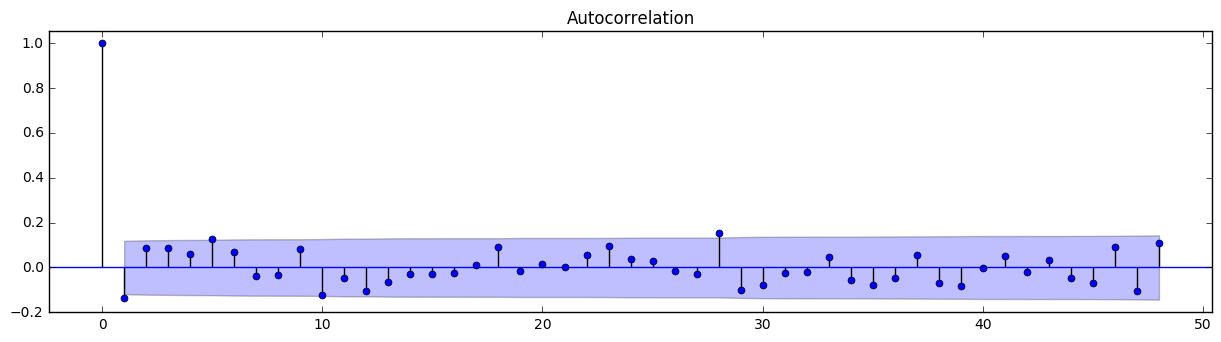

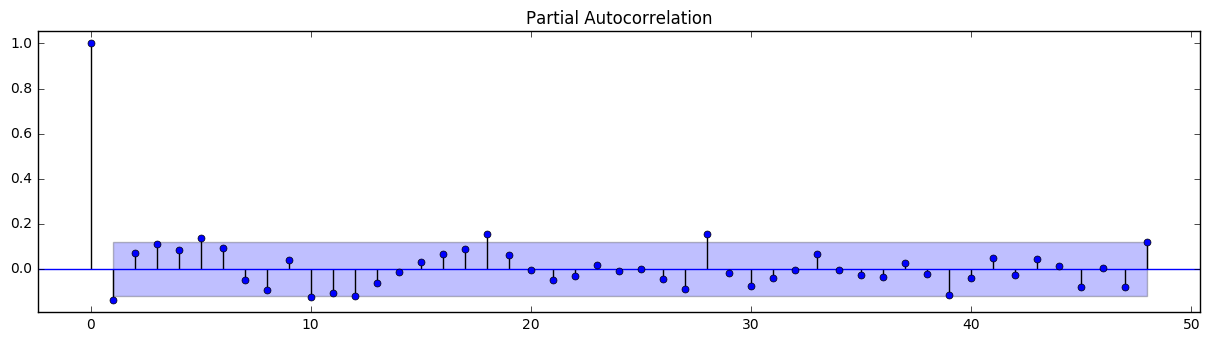

In [7]:
#Гипотеза нестационарности отвергается, и визуально тренда больше нет.

#Подбор модели. Выбор начальных приближений

#Посмотрим на ACF и PACF

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.zp_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.zp_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [8]:
#Начальные приближения: Q=1, q=1, P=1, p=1
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
from itertools import product
# составим комбинаций параметров для подобора
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [11]:
#Обучение и сравнение моделей-кандидатов
%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.zp_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 0 ns
wrong parameters: (0, 0, 0, 0)


In [12]:
result_table = pandas.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print result_table.sort_values(by = 'aic', ascending=True).head()

      parameters       aic
9   (1, 0, 1, 0)  0.340521
10  (1, 0, 1, 1)  0.492412
8   (1, 0, 0, 1)  0.774438
5   (0, 1, 1, 0)  1.170768
6   (0, 1, 1, 1)  1.342396


In [13]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                             zp_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sat, 15 Apr 2017   AIC                              0.341
Time:                                    22:16:35   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Критерий Стьюдента: p=0.090794
Критерий Дики-Фуллера: p=0.000003


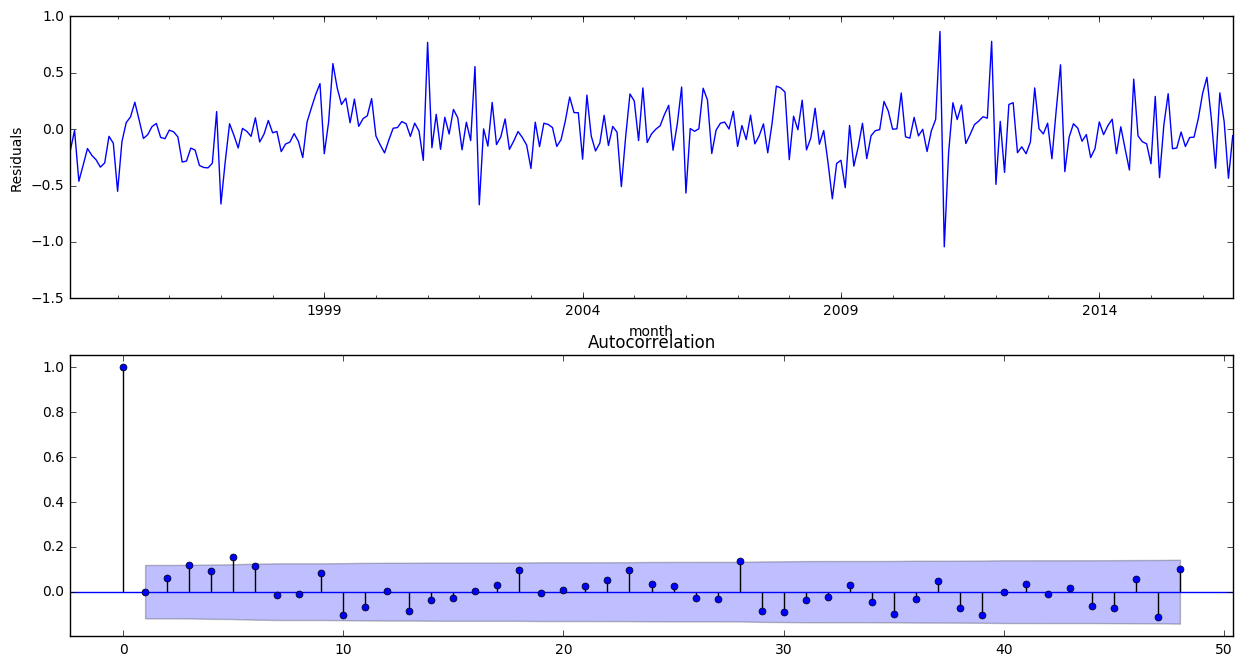

In [14]:
# Анализ остатков построенной модели
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print "Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1]
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]

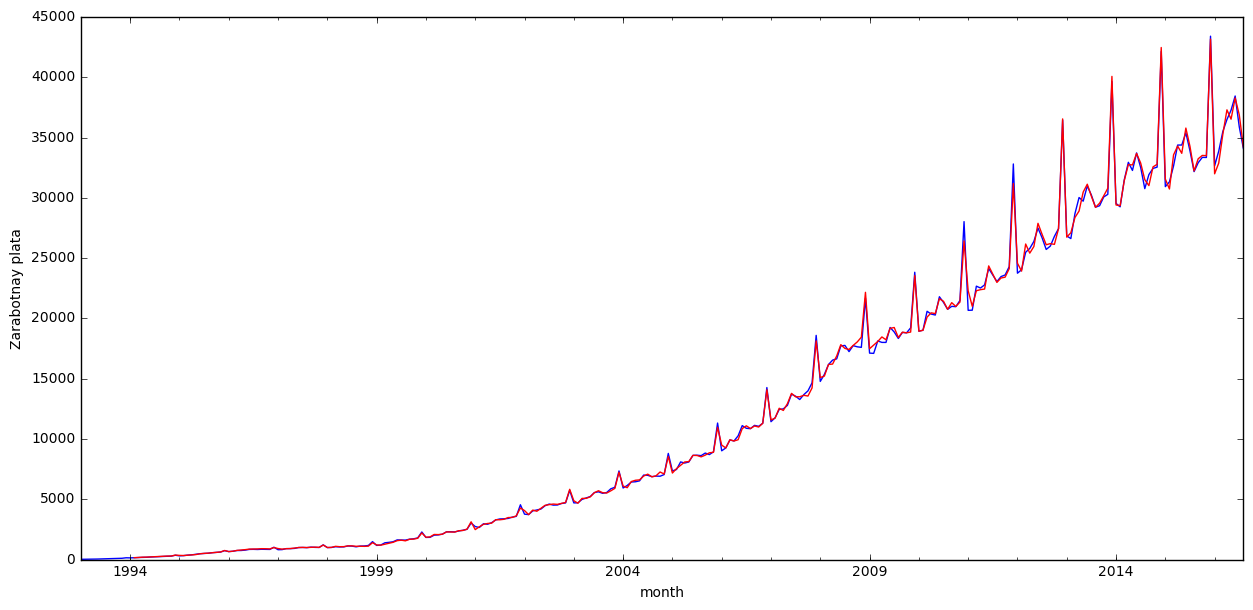

In [15]:
# Остатки несмещены (подтверждается критерием Стьюдента)
# стационарны (подтверждается критерием Дики-Фуллера и визуально),
# неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

# Проверим модель на данных:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel(u'Zarabotnay plata')
pylab.show()



In [ ]:
# Прогноз

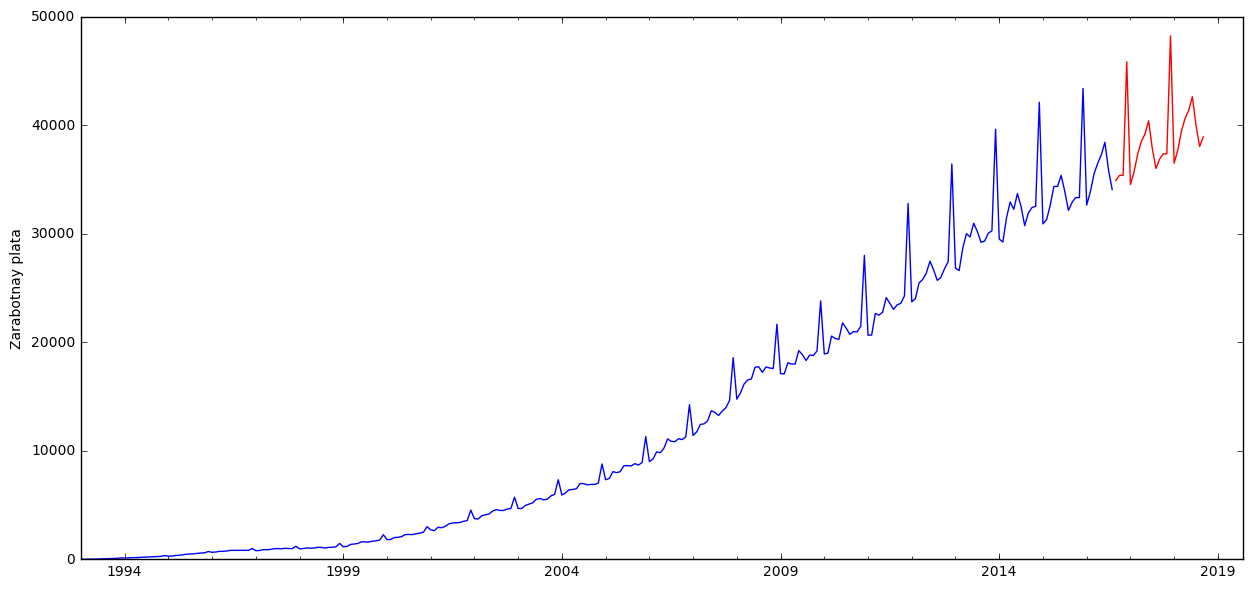

In [18]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pandas.DataFrame(index=date_list, columns= data2.columns)
data2 = pandas.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=data.shape[0], end=data.shape[0] + 24), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel(u'Zarabotnay plata')
pylab.show()